In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# regular imports
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Lightning import
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
# from pl_bolts.datamodules.mnist_datamodule import LightningDataModule, MNISTDataModule,

# PyTorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
print(f'Cuda available: {torch.cuda.is_available()}')

import wandb
wandb.login()

# internal imports
from src.callbacks import ImagePredictionLogger
from src.dataset import ComposeMany, ComposeManyTorch, MNISTDataModule2
from src.losses import log_softmax, simsiam_loss
from src.models import accuracy, feature_std, CNN, BaseLitModel, SimSiam
from src.utils import sweep_iteration

Cuda available: True


wandb: Currently logged in as: alkalait (use `wandb login --relogin` to force relogin)


---

In [ ]:
# Augmentator

AUG_KWARGS = dict(border_mode=A.cv2.BORDER_CONSTANT, value=0,
                  interpolation=A.cv2.INTER_LANCZOS4)

train_transforms = ComposeMany([
    #A.RandomCrop(width=24, height=24),
    #A.HorizontalFlip(p=0.5),
    #A.GridDistortion(p=0.5, distort_limit=.3, **AUG_KWARGS),
    A.ElasticTransform(p=0.5, sigma=1, alpha=3, alpha_affine=0, **AUG_KWARGS),
    A.ElasticTransform(p=0.5, sigma=1, alpha=1, alpha_affine=3, **AUG_KWARGS),
    A.ShiftScaleRotate(p=1.0, scale_limit=.2, rotate_limit=0, **AUG_KWARGS),
    A.ShiftScaleRotate(p=1.0, scale_limit=0, rotate_limit=25, **AUG_KWARGS),
    #A.CoarseDropout(p=1.0, max_holes=8, max_height=4, max_width=4,
    #                min_holes=1, min_height=4, min_width=4),
    #A.RandomBrightnessContrast(p=0.2),
    #A.Blur(blur_limit=4),
    A.Normalize(mean=(0.0,), std=(1,)),  # , max_pixel_value=255),
    ToTensorV2()
], n_aug=2)

In [ ]:
## Lightning datamodule. Comes with its own train / val / test dataloader.
mnist = MNISTDataModule2(data_dir='../data/', batch_size=512, train_transforms=train_transforms)
mnist.prepare_data()
mnist.setup()

## Backbone arch
cnn = CNN(num_channels=mnist.dims[0], num_classes=mnist.num_classes)

## Metrics: (name of log-entry, metric)
metrics = (('acc', accuracy),)

model = BaseLitModel(
    datamodule=mnist, backbone=cnn, loss_func=log_softmax, metrics=metrics,
    lr=1e-3, flood_height=0.03
)

In [ ]:
wandb_logger = WandbLogger(project='SimSiam-Lightning', job_type='train')
callbacks = [
    LearningRateMonitor(),  # log the LR
    ImagePredictionLogger(mnist.val_dataloader(batch_size=32), n_samples=32),
]

trainer = Trainer(
    max_epochs=200, gpus=-1,  # all GPUs
    logger=wandb_logger, callbacks=callbacks,
    accumulate_grad_batches=1, gradient_clip_val=0,  # 0.5
    progress_bar_refresh_rate=20,
    fast_dev_run=True,
)

In [ ]:
trainer.fit(model, mnist)

---

In [ ]:
trainer.test()

In [ ]:
wandb.finish()

---

# LR finder

In [ ]:
# # Learning rate finder
# lr_finder = trainer.tuner.lr_find(model, num_training=3000, mode='linear', max_lr=1e-2)
# # lr_finder.results  # Results can be found in
# fig = lr_finder.plot(suggest=True)
# lr_finder.suggestion()
# model.hparams.lr = new_lr  # update hparams of the model

# Hyperparameter sweep 

In [ ]:
# from src.sweeps import sweep_config

# sweep_id = wandb.sweep(sweep_config, project=proj)

# wandb.agent(sweep_id, function=sweep_iteration, project=proj)

---

# SimSiam

In [3]:
# Augmentator
AUG_KWARGS = dict(border_mode=A.cv2.BORDER_CONSTANT, value=0,
                  interpolation=A.cv2.INTER_LANCZOS4)
# transforms = ComposeMany([
#     #A.ElasticTransform(p=0.5, sigma=1, alpha=3, alpha_affine=0, **AUG_KWARGS),
#     #A.ElasticTransform(p=0.5, sigma=1, alpha=1, alpha_affine=3, **AUG_KWARGS),
#     A.ShiftScaleRotate(p=1.0, scale_limit=.2, rotate_limit=0, **AUG_KWARGS),
#     A.ShiftScaleRotate(p=1.0, scale_limit=0, rotate_limit=10, **AUG_KWARGS),
#     A.Normalize(mean=(0.0,), std=(1,)),  # , max_pixel_value=255),
#     ToTensorV2()
# ], n_aug=2)

transforms = ComposeManyTorch([
    T.RandomResizedCrop(28, scale=(0.6, 1.0)),
    #T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    #T.RandomGrayscale(p=0.2),
    T.RandomApply([T.GaussianBlur(kernel_size=28//20*2+1, sigma=(0.1, 2.0))], p=0.5),
    T.ToTensor(),
    T.Normalize([0.1307], [0.3081]),
], n_aug=2)

In [4]:
## Lightning datamodule. Comes with its own train / val / test dataloader.
mnist = MNISTDataModule2(data_dir='../data/',
                         batch_size=512,
                         train_transforms=transforms,
                         val_transforms=transforms)
# mnist.prepare_data(); mnist.setup()

## Backbone arch
cnn = CNN(num_channels=mnist.dims[0], num_classes=mnist.num_classes)
simsiam = SimSiam(backbone=cnn)

model = BaseLitModel(
    datamodule=mnist, backbone=simsiam,
    loss_func=simsiam_loss,
    metrics=(('featstd', feature_std),),
    lr=0.05 * mnist.train_dataloader().batch_size / 256,  # 1e-3
    #flood_height=0.03
)

Logging metrics: ['featstd']


In [5]:
wandb_logger = WandbLogger(project='SimSiam-Lightning', job_type='train')
callbacks = [
    LearningRateMonitor(),  # log the LR
    #ImagePredictionLogger(mnist.val_dataloader(batch_size=32), n_samples=32),
]

trainer = Trainer(
    max_epochs=5, #gpus=-1,  # all GPUs
    logger=wandb_logger, callbacks=callbacks,
    accumulate_grad_batches=1, gradient_clip_val=0,  # 0.5
    progress_bar_refresh_rate=20,
    #fast_dev_run=True,
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/freddie/venv/wotus/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [ ]:
trainer.fit(model, mnist)

---

In [6]:
from src.losses import negcosim, simsiam_loss

In [27]:
simsiam.train(False);
print(simsiam.training)

False


In [13]:
x_train, y = next(iter(mnist.train_dataloader()))
x_val, y = next(iter(mnist.val_dataloader()))
print(x_train.shape)
print(x_val.shape)

torch.Size([512, 2, 28, 28])
torch.Size([512, 2, 28, 28])


In [ ]:
# cnn.avgpool(cnn.features(x[:,[0]])).shape

In [28]:
x1, x2 = x_val[:, [0]], x_val[:, [1]]
print(x1.shape)
print(x2.shape)

torch.Size([512, 1, 28, 28])
torch.Size([512, 1, 28, 28])


In [29]:
print(((x1.view(512,-1) - x2.view(512,-1))**2).mean())
print(negcosim(x1.view(512,-1), x2.view(512,-1)))

tensor(0.9459)
tensor(-0.4566)


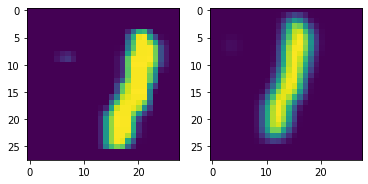

In [33]:
i = 112
fig, ax = plt.subplots(1,2)
ax[0].imshow(x1[i][0], );
ax[1].imshow(x2[i][0]);

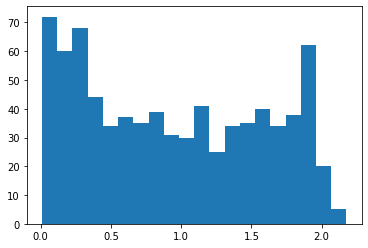

In [34]:
plt.hist(((x1.view(512,-1) - x2.view(512,-1))**2).mean(dim=0).numpy(), bins=20);

In [ ]:
simsiam.__call__??

The following shows that dropout is enough to cause a difference between x1 and x2 during training. When dropout is paused in validation, f yields identical results

In [47]:
# z1, z2, p1, p2 = simsiam(x_train)
# z1, z2, p1, p2 = simsiam(x_val)
z1, z2 = simsiam.f(x1), simsiam.f(x2)  # projections
# p1, p2 = simsiam.h(z1), simsiam.h(z2)  # centroid predictions

print(((z1 - z2)**2).mean())
print(negcosim(z1, z2))

tensor(1.7245e-06, grad_fn=<MeanBackward0>)
tensor(-0.9999, grad_fn=<NegBackward>)


In [ ]:
((z1 - z2)**2).mean()

In [ ]:
# simsiam_loss((x_train, y), simsiam)
# simsiam_loss((x_val, y), simsiam)

In [ ]:
print(((F.normalize(z1) - F.normalize(p1))**2).mean())
print(((F.normalize(z2) - F.normalize(p2))**2).mean())

In [ ]:
print(negcosim(p1, z2))
print(negcosim(p2, z1))
print((negcosim(p1, z2) + negcosim(p2, z1)) / 2)

---

In [ ]:
import torchvision.transforms as T
from src.dataset import ComposeManyTorch

transforms = ComposeManyTorch([
    T.RandomResizedCrop(28, scale=(0.6, 1.0)),
    #T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    #T.RandomGrayscale(p=0.2),
    T.RandomApply([T.GaussianBlur(kernel_size=28//20*2+1, sigma=(0.1, 2.0))], p=0.5),
    T.ToTensor(),
    T.Normalize([0.1307], [0.3081]),
], n_aug=2)

mnist = MNISTDataModule2(data_dir='../data/',
                         batch_size=32,
                         train_transforms=transforms,
                         val_transforms=transforms)

x, y = next(iter(mnist.val_dataloader()))

i = 1
fig, ax = plt.subplots(1,2)
ax[0].imshow(x[i][0], );
ax[1].imshow(x[i][1]);

In [ ]:
x[:,0].std(dim=0).mean()
x.shape